In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
import global_parameters as gp
from supportfunctions import PDESolver_2d, finiteDiff
import matplotlib.pyplot as plt
from numba import njit,jit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode
import plotly.graph_objects as go
from scipy import interpolate
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Smooth Ambiguity
Base line model, no ambiguity:
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & - \delta \phi(y) + \delta\eta \log\tilde e \\
&  + \frac{\xi_m}{2} h'h + \frac{d\phi(y)}{dy} \tilde e (\theta + \sigma_y h) + \frac{1}{2}\frac{d^2\phi(y)}{dy^2}|\sigma_y|^2(\tilde e)^2\\
                           & + (\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h)
\end{aligned}
$$

In [2]:
δ = 0.01
η = 0.032
# μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
μ = np.mean(θ_list)
σy = 1.2*μ/3
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
ȳ= 2
ξₘ = 0.002
ξₘ = 10000
ξₐ = 1/4000
years = np.linspace(0,100)

In [3]:
# y grid
n_y = 400
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)
dy = y_grid[1] - y_grid[0]

In [4]:
# no ambguity
def solve_no_ambiguity(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ, σy, γ1, γ2, γ3, ȳ = args
    hy = y_grid[1] - y_grid[0]
    # initialize the while loop
    episode = 0
    lhs_error = 1
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ϕ =  - δ*η*y_grid**2
    ems = - δ*η/((η-1)*dΛ*θ)
    ems_old = ems
    h_star = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy)
        dϕdyy = derivative_1d(ϕ, 2, hy)
        temp = dϕdy + (η-1)*dΛ
        a = dϕdyy*σy**2  
        b = temp*θ
        c = δ*η
        Δ = b**2 - 4*a*c
        ems_new = (-b - np.sqrt(Δ))/(2*a)
        ems_new[ems_new <= 1e-15] = 1e-15    
        ems = ems_new*1 + ems_old*0
        # coefficients
        A = -δ*np.ones(y_grid.shape)
        B = ems*θ
        C = σy**2*ems**2/2
        D = δ*η*np.log(ems) + (η-1)*dΛ*ems*θ

        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems

In [5]:
@njit 
def simulate_no_amb(y_grid, ems, θ,  dt=1, T=100):
    # initiate
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    # interpolate
    y0 = θ*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        ems_t[t] = ems_point
        dy = ems_point*θ*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t

In [6]:
γ3 = np.average(γ3_list, weights=[0.5, 0.5, 0])
args = (δ, η, μ, σy, γ1, γ2, γ3, ȳ)
ϕ_avg_no_amb, ems_avg_no_amb = solve_no_ambiguity(y_grid, args)

episode: 1,	 ode error: 0.0017788154322649187,	 ft error: 0.0014231140735719834
episode: 2,	 ode error: 0.001505887161853751,	 ft error: 0.0013365194316900823
episode: 3,	 ode error: 0.0013675753150904756,	 ft error: 0.0012708542018790197
episode: 4,	 ode error: 0.001282758855593725,	 ft error: 0.0012188987503942224
episode: 5,	 ode error: 0.0012232738585457937,	 ft error: 0.0011767949584224728
episode: 6,	 ode error: 0.0011774370213175071,	 ft error: 0.0011410586594677492
episode: 7,	 ode error: 0.0011430643127805875,	 ft error: 0.0011134204891813208
episode: 8,	 ode error: 0.0011130146849199938,	 ft error: 0.0010879558305827782
episode: 9,	 ode error: 0.0010871184535844107,	 ft error: 0.0010654322891791475
episode: 10,	 ode error: 0.0010645676605758685,	 ft error: 0.0010453877072341936
episode: 11,	 ode error: 0.001044241246385923,	 ft error: 0.0010271098839507563
episode: 12,	 ode error: 0.0010255461332115891,	 ft error: 0.001010296494211419
episode: 13,	 ode error: 0.00100891591473

episode: 132,	 ode error: 0.0004455512302767588,	 ft error: 0.00044481330798502167
episode: 133,	 ode error: 0.00044336168674075354,	 ft error: 0.0004426306017344765
episode: 134,	 ode error: 0.00044118504335602805,	 ft error: 0.00044046055332751244
episode: 135,	 ode error: 0.00043902101728863054,	 ft error: 0.0004383028827232317
episode: 136,	 ode error: 0.00043686754047946974,	 ft error: 0.00043675369217024973
episode: 137,	 ode error: 0.00043473207182253876,	 ft error: 0.0004340265361136552
episode: 138,	 ode error: 0.00043260311950273436,	 ft error: 0.00043249858669669927
episode: 139,	 ode error: 0.00043048837432275837,	 ft error: 0.0004303907992992545
episode: 140,	 ode error: 0.00042838522975620266,	 ft error: 0.00042829212179396753
episode: 141,	 ode error: 0.00042629242366321897,	 ft error: 0.00042620261311670377
episode: 142,	 ode error: 0.0004242094466980805,	 ft error: 0.00042412238478162917
episode: 143,	 ode error: 0.0004221361041001838,	 ft error: 0.00042205152083816627

episode: 264,	 ode error: 0.00022546048715366325,	 ft error: 0.0002254498256221843
episode: 265,	 ode error: 0.00022426498800486104,	 ft error: 0.00022425583464021997
episode: 266,	 ode error: 0.00022307618644846745,	 ft error: 0.0002230685451123926
episode: 267,	 ode error: 0.00022189405422851592,	 ft error: 0.00022188792837889623
episode: 268,	 ode error: 0.00022071856274736234,	 ft error: 0.0002207139554492634
episode: 269,	 ode error: 0.00021954968308294273,	 ft error: 0.00021954659701765394
episode: 270,	 ode error: 0.0002183873860053179,	 ft error: 0.00021838582348124302
episode: 271,	 ode error: 0.00021723164199312828,	 ft error: 0.00021723160495844737
episode: 272,	 ode error: 0.00021608242124942373,	 ft error: 0.00021608391129794569
episode: 273,	 ode error: 0.00021493969371721728,	 ft error: 0.00021494271210245608
episode: 274,	 ode error: 0.00021380342909458087,	 ft error: 0.00021380797673736335
episode: 275,	 ode error: 0.0002126735968495054,	 ft error: 0.000212679674349500

episode: 387,	 ode error: 0.00011933818559245978,	 ft error: 0.00011948430416306814
episode: 388,	 ode error: 0.00011873991208299743,	 ft error: 0.00011888691071181012
episode: 389,	 ode error: 0.00011814486715794608,	 ft error: 0.00011829273994692913
episode: 390,	 ode error: 0.00011755303084597102,	 ft error: 0.00011770177194942814
episode: 391,	 ode error: 0.00011696438333194908,	 ft error: 0.00011711398695717543
episode: 392,	 ode error: 0.00011637890495632341,	 ft error: 0.00011652936536111122
episode: 393,	 ode error: 0.00011579657621434787,	 ft error: 0.00011594788771685886
episode: 394,	 ode error: 0.00011521737775521549,	 ft error: 0.00011536953471724676
episode: 395,	 ode error: 0.00011464129038127823,	 ft error: 0.00011479428722598514
episode: 396,	 ode error: 0.00011406829504725111,	 ft error: 0.00011422212625277854
episode: 397,	 ode error: 0.00011349837285916668,	 ft error: 0.00011365303295862254
episode: 398,	 ode error: 0.00011293150507363139,	 ft error: 0.0001130869886

episode: 527,	 ode error: 5.99666806172448e-05,	 ft error: 6.0196694886457035e-05
episode: 528,	 ode error: 5.967829241046267e-05,	 ft error: 5.9908694778898486e-05
episode: 529,	 ode error: 5.93913557447454e-05,	 ft error: 5.962214388172127e-05
episode: 530,	 ode error: 5.910586263857217e-05,	 ft error: 5.933703407614196e-05
episode: 531,	 ode error: 5.882180515788592e-05,	 ft error: 5.905335776002404e-05
episode: 532,	 ode error: 5.853917541838254e-05,	 ft error: 5.8771106645367596e-05
episode: 533,	 ode error: 5.825796558314429e-05,	 ft error: 5.849027303566716e-05
episode: 534,	 ode error: 5.7978167863269705e-05,	 ft error: 5.821084907213966e-05
episode: 535,	 ode error: 5.769977451689195e-05,	 ft error: 5.7932827191136314e-05
episode: 536,	 ode error: 5.742277784897675e-05,	 ft error: 5.76561998771874e-05
episode: 537,	 ode error: 5.714717021341998e-05,	 ft error: 5.738095887624732e-05
episode: 538,	 ode error: 5.687294400848512e-05,	 ft error: 5.710709732211865e-05
episode: 539,	

episode: 677,	 ode error: 2.9359318327071586e-05,	 ft error: 2.962537355403102e-05
episode: 678,	 ode error: 2.922105461694016e-05,	 ft error: 2.948721520822558e-05
episode: 679,	 ode error: 2.908345085954583e-05,	 ft error: 2.934971489389667e-05
episode: 680,	 ode error: 2.89465037408256e-05,	 ft error: 2.9212869284469166e-05
episode: 681,	 ode error: 2.8810209965000454e-05,	 ft error: 2.9076675040924187e-05
episode: 682,	 ode error: 2.8674566254137997e-05,	 ft error: 2.8941128924648656e-05
episode: 683,	 ode error: 2.853956934823485e-05,	 ft error: 2.8806227705911274e-05
episode: 684,	 ode error: 2.840521600565749e-05,	 ft error: 2.8671967929859897e-05
episode: 685,	 ode error: 2.8271503002357283e-05,	 ft error: 2.8538346405921716e-05
episode: 686,	 ode error: 2.813842713186637e-05,	 ft error: 2.8405359930478807e-05
episode: 687,	 ode error: 2.8005985204707963e-05,	 ft error: 2.827300545966971e-05
episode: 688,	 ode error: 2.7874174049577483e-05,	 ft error: 2.814127958106205e-05
epis

episode: 819,	 ode error: 1.5039127054801687e-05,	 ft error: 1.5229165162231977e-05
episode: 820,	 ode error: 1.4968567105331956e-05,	 ft error: 1.5152769438248986e-05
episode: 821,	 ode error: 1.4898354105397841e-05,	 ft error: 1.5076018983761763e-05
episode: 822,	 ode error: 1.4828488861244387e-05,	 ft error: 1.4998780814359791e-05
episode: 823,	 ode error: 1.4758972687081186e-05,	 ft error: 1.4920883150808714e-05
episode: 824,	 ode error: 1.4689807561185804e-05,	 ft error: 1.4842101168944615e-05
episode: 825,	 ode error: 1.4620996327518337e-05,	 ft error: 1.4762141478571097e-05
episode: 826,	 ode error: 1.455254303552229e-05,	 ft error: 1.4680595713685112e-05
episode: 827,	 ode error: 1.4484453391395763e-05,	 ft error: 1.4596902222728064e-05
episode: 828,	 ode error: 1.4416735547618208e-05,	 ft error: 1.4510232352419699e-05
episode: 829,	 ode error: 1.4349401313169309e-05,	 ft error: 1.4419347501154478e-05
episode: 830,	 ode error: 1.4282468441060257e-05,	 ft error: 1.43222364371956

episode: 953,	 ode error: 7.935657604017502e-06,	 ft error: 8.263485939454437e-06
episode: 954,	 ode error: 7.897456648594137e-06,	 ft error: 8.22517538433265e-06
episode: 955,	 ode error: 7.859431295396133e-06,	 ft error: 8.187042922098525e-06
episode: 956,	 ode error: 7.821580719340865e-06,	 ft error: 8.149087698898032e-06
episode: 957,	 ode error: 7.78390409907851e-06,	 ft error: 8.111308989940577e-06
episode: 958,	 ode error: 7.746400617821892e-06,	 ft error: 8.073705775046847e-06
episode: 959,	 ode error: 7.70906946294446e-06,	 ft error: 8.036277211835124e-06
episode: 960,	 ode error: 7.671909825966521e-06,	 ft error: 7.999022420222362e-06
episode: 961,	 ode error: 7.63492090260305e-06,	 ft error: 7.961940516355386e-06
episode: 962,	 ode error: 7.598101892576452e-06,	 ft error: 7.925030674806507e-06
episode: 963,	 ode error: 7.5614519997511086e-06,	 ft error: 7.88829202735819e-06
episode: 964,	 ode error: 7.5249704320033825e-06,	 ft error: 7.851723740973093e-06
episode: 965,	 ode 

episode: 1085,	 ode error: 4.1475199338645435e-06,	 ft error: 4.470356214832568e-06
episode: 1086,	 ode error: 4.126842769612148e-06,	 ft error: 4.4495547303162e-06
episode: 1087,	 ode error: 4.106261670614895e-06,	 ft error: 4.428850220357846e-06
episode: 1088,	 ode error: 4.0857762007846625e-06,	 ft error: 4.40824212281458e-06
episode: 1089,	 ode error: 4.065385922381328e-06,	 ft error: 4.387730143338524e-06
episode: 1090,	 ode error: 4.045090396433658e-06,	 ft error: 4.367313785405558e-06
episode: 1091,	 ode error: 4.024889182437249e-06,	 ft error: 4.346992592043261e-06
episode: 1092,	 ode error: 4.004781838226157e-06,	 ft error: 4.32676610091313e-06
episode: 1093,	 ode error: 3.984767919526749e-06,	 ft error: 4.306633927207241e-06
episode: 1094,	 ode error: 3.964846979912927e-06,	 ft error: 4.286595650451752e-06
episode: 1095,	 ode error: 3.94501857072405e-06,	 ft error: 4.266650815848427e-06
episode: 1096,	 ode error: 3.925282241188971e-06,	 ft error: 4.246798885609859e-06
episode

episode: 1219,	 ode error: 2.3323673427591747e-06,	 ft error: 2.3679501835738304e-06
episode: 1220,	 ode error: 2.326190455724357e-06,	 ft error: 2.3564252363966753e-06
episode: 1221,	 ode error: 2.320031922431866e-06,	 ft error: 2.344954676431847e-06
episode: 1222,	 ode error: 2.3138916891833096e-06,	 ft error: 2.3335384883212593e-06
episode: 1223,	 ode error: 2.3077697022647373e-06,	 ft error: 2.3221764843215737e-06
episode: 1224,	 ode error: 2.301682330264356e-06,	 ft error: 2.310868589515865e-06
episode: 1225,	 ode error: 2.2957616703942136e-06,	 ft error: 2.2996146297841564e-06
episode: 1226,	 ode error: 2.289869737310754e-06,	 ft error: 2.2884145375184906e-06
episode: 1227,	 ode error: 2.2840063959316567e-06,	 ft error: 2.277268095809045e-06
episode: 1228,	 ode error: 2.2781715165108812e-06,	 ft error: 2.266175280323431e-06
episode: 1229,	 ode error: 2.2723649631009677e-06,	 ft error: 2.2551358338137226e-06
episode: 1230,	 ode error: 2.2665866075490568e-06,	 ft error: 2.244149614

episode: 1349,	 ode error: 1.7476015228673459e-06,	 ft error: 1.396596751695086e-06
episode: 1350,	 ode error: 1.744417535998427e-06,	 ft error: 1.3924233559919896e-06
episode: 1351,	 ode error: 1.7412496786198836e-06,	 ft error: 1.388262322934523e-06
episode: 1352,	 ode error: 1.7380978754752375e-06,	 ft error: 1.3841135926400314e-06
episode: 1353,	 ode error: 1.7349620500626954e-06,	 ft error: 1.3799771935926741e-06
episode: 1354,	 ode error: 1.7318421314296275e-06,	 ft error: 1.3758530417161872e-06
episode: 1355,	 ode error: 1.7287380446397746e-06,	 ft error: 1.3717410856511902e-06
episode: 1356,	 ode error: 1.7256497139989655e-06,	 ft error: 1.3676413124219522e-06
episode: 1357,	 ode error: 1.7225770662427265e-06,	 ft error: 1.3635536957647596e-06
episode: 1358,	 ode error: 1.7195200290251195e-06,	 ft error: 1.3594781708356485e-06
episode: 1359,	 ode error: 1.7164785282312769e-06,	 ft error: 1.3554147660493898e-06
episode: 1360,	 ode error: 1.7134524949609094e-06,	 ft error: 1.3513

episode: 1493,	 ode error: 1.423718127274785e-06,	 ft error: 9.074852237260049e-07
episode: 1494,	 ode error: 1.4222251416355874e-06,	 ft error: 9.047721182681157e-07
episode: 1495,	 ode error: 1.4207403179018947e-06,	 ft error: 9.020670455051061e-07
episode: 1496,	 ode error: 1.4192636158708396e-06,	 ft error: 8.993699822032464e-07
episode: 1497,	 ode error: 1.4177949957391378e-06,	 ft error: 8.966809237481721e-07
episode: 1498,	 ode error: 1.416334419499269e-06,	 ft error: 8.939998423958725e-07
episode: 1499,	 ode error: 1.4148818488408954e-06,	 ft error: 8.913267037294337e-07
episode: 1500,	 ode error: 1.413437244660639e-06,	 ft error: 8.886614796232059e-07
episode: 1501,	 ode error: 1.4120005679227766e-06,	 ft error: 8.860041931027518e-07
episode: 1502,	 ode error: 1.4105717832686021e-06,	 ft error: 8.833547432534247e-07
episode: 1503,	 ode error: 1.4091508491830928e-06,	 ft error: 8.807131711303466e-07
episode: 1504,	 ode error: 1.4077377298388422e-06,	 ft error: 8.780794389974996

episode: 1632,	 ode error: 1.2796679524111274e-06,	 ft error: 5.984924903584821e-07
episode: 1633,	 ode error: 1.2790010633912633e-06,	 ft error: 5.967025902784788e-07
episode: 1634,	 ode error: 1.2783382949070718e-06,	 ft error: 5.949180211193654e-07
episode: 1635,	 ode error: 1.2776796283192745e-06,	 ft error: 5.93138755403122e-07
episode: 1636,	 ode error: 1.2770250438015542e-06,	 ft error: 5.913647585046682e-07
episode: 1637,	 ode error: 1.2763745200114994e-06,	 ft error: 5.895960201081815e-07
episode: 1638,	 ode error: 1.2757280361323743e-06,	 ft error: 5.878325183214517e-07
episode: 1639,	 ode error: 1.27508557104224e-06,	 ft error: 5.860742569724353e-07
episode: 1640,	 ode error: 1.2744471054619761e-06,	 ft error: 5.843212291453681e-07
episode: 1641,	 ode error: 1.2738126206532081e-06,	 ft error: 5.825733857822701e-07
episode: 1642,	 ode error: 1.273182095062593e-06,	 ft error: 5.808307201292847e-07
episode: 1643,	 ode error: 1.272555508157456e-06,	 ft error: 5.790932350197935e-

episode: 1770,	 ode error: 1.2665802707019155e-06,	 ft error: 3.958610674791493e-07
episode: 1771,	 ode error: 1.266809562851961e-06,	 ft error: 3.946768464708576e-07
episode: 1772,	 ode error: 1.267036955445919e-06,	 ft error: 3.9349611266152146e-07
episode: 1773,	 ode error: 1.2672624588199225e-06,	 ft error: 3.923189163465568e-07
episode: 1774,	 ode error: 1.2674860832694469e-06,	 ft error: 3.911452052529629e-07
episode: 1775,	 ode error: 1.267707839089317e-06,	 ft error: 3.8997498473525294e-07
episode: 1776,	 ode error: 1.2679277366922648e-06,	 ft error: 3.888081868500907e-07
episode: 1777,	 ode error: 1.2681457862144963e-06,	 ft error: 3.876449024160326e-07
episode: 1778,	 ode error: 1.268361997703801e-06,	 ft error: 3.8648506497003987e-07
episode: 1779,	 ode error: 1.2685763813486436e-06,	 ft error: 3.8532865086204904e-07
episode: 1780,	 ode error: 1.2687889471993071e-06,	 ft error: 3.8417568212304837e-07
episode: 1781,	 ode error: 1.2689997052485577e-06,	 ft error: 3.83026893813

episode: 1913,	 ode error: 1.28430776229015e-06,	 ft error: 2.579242676844137e-07
episode: 1914,	 ode error: 1.2843505720224174e-06,	 ft error: 2.571529183227154e-07
episode: 1915,	 ode error: 1.2843925562555647e-06,	 ft error: 2.5638387280100633e-07
episode: 1916,	 ode error: 1.2844337201318545e-06,	 ft error: 2.5561710225348777e-07
episode: 1917,	 ode error: 1.2844740688402242e-06,	 ft error: 2.548525939241597e-07
episode: 1918,	 ode error: 1.2845136075050468e-06,	 ft error: 2.540903558621392e-07
episode: 1919,	 ode error: 1.2845523411839088e-06,	 ft error: 2.5333038213467185e-07
episode: 1920,	 ode error: 1.2845902748648448e-06,	 ft error: 2.5257267826974317e-07
episode: 1921,	 ode error: 1.284627413654664e-06,	 ft error: 2.518171905718791e-07
episode: 1922,	 ode error: 1.2846637624734755e-06,	 ft error: 2.510639864986934e-07
episode: 1923,	 ode error: 1.2846993263118623e-06,	 ft error: 2.5031298620664666e-07
episode: 1924,	 ode error: 1.2847341101530885e-06,	 ft error: 2.4956422473

episode: 2059,	 ode error: 1.2840241226843153e-06,	 ft error: 1.665395856637053e-07
episode: 2060,	 ode error: 1.2839897254450267e-06,	 ft error: 1.6604126936807056e-07
episode: 2061,	 ode error: 1.2839550331274316e-06,	 ft error: 1.6554439054526177e-07
episode: 2062,	 ode error: 1.2839200481275627e-06,	 ft error: 1.6504901644472567e-07
episode: 2063,	 ode error: 1.2838847727006148e-06,	 ft error: 1.6455512702462372e-07
episode: 2064,	 ode error: 1.2838492093187313e-06,	 ft error: 1.6406267075210387e-07
episode: 2065,	 ode error: 1.2838133603990868e-06,	 ft error: 1.635716831543029e-07
episode: 2066,	 ode error: 1.2837772281962256e-06,	 ft error: 1.6308217505589528e-07
episode: 2067,	 ode error: 1.2837408150622159e-06,	 ft error: 1.6259410165475607e-07
episode: 2068,	 ode error: 1.283704123333188e-06,	 ft error: 1.6210748669346725e-07
episode: 2069,	 ode error: 1.2836671553405018e-06,	 ft error: 1.6162230577025188e-07
episode: 2070,	 ode error: 1.2836299133951886e-06,	 ft error: 1.6113

episode: 2202,	 ode error: 1.2770633995877662e-06,	 ft error: 1.0849826267746629e-07
episode: 2203,	 ode error: 1.2770058816148513e-06,	 ft error: 1.0817367790868135e-07
episode: 2204,	 ode error: 1.2769483049779253e-06,	 ft error: 1.078500465439188e-07
episode: 2205,	 ode error: 1.2768906707718154e-06,	 ft error: 1.0752737079205987e-07
episode: 2206,	 ode error: 1.2768329799647685e-06,	 ft error: 1.0720567690525318e-07
episode: 2207,	 ode error: 1.2767752336672244e-06,	 ft error: 1.0688490287291685e-07
episode: 2208,	 ode error: 1.2767174329334613e-06,	 ft error: 1.0656509732513235e-07
episode: 2209,	 ode error: 1.2766595787569337e-06,	 ft error: 1.062462389710602e-07
episode: 2210,	 ode error: 1.2766016721693684e-06,	 ft error: 1.0592832479228154e-07
episode: 2211,	 ode error: 1.2765437141914332e-06,	 ft error: 1.0561135320441561e-07
episode: 2212,	 ode error: 1.2764857057161855e-06,	 ft error: 1.0529535209025109e-07
episode: 2213,	 ode error: 1.276427647871304e-06,	 ft error: 1.0498

episode: 2336,	 ode error: 1.2691719386263996e-06,	 ft error: 7.261468595402369e-08
episode: 2337,	 ode error: 1.269113751752786e-06,	 ft error: 7.239735912619358e-08
episode: 2338,	 ode error: 1.2690556001309218e-06,	 ft error: 7.218069668588993e-08
episode: 2339,	 ode error: 1.2689974842602448e-06,	 ft error: 7.196464418592527e-08
episode: 2340,	 ode error: 1.2689394045979087e-06,	 ft error: 7.174924495969201e-08
episode: 2341,	 ode error: 1.2688813614955747e-06,	 ft error: 7.153449155944402e-08
episode: 2342,	 ode error: 1.268823355289779e-06,	 ft error: 7.132039143292745e-08
episode: 2343,	 ode error: 1.2687653864160457e-06,	 ft error: 7.11069079543473e-08
episode: 2344,	 ode error: 1.26870745527e-06,	 ft error: 7.089407403719032e-08
episode: 2345,	 ode error: 1.2686495622611454e-06,	 ft error: 7.068185911562885e-08
episode: 2346,	 ode error: 1.2685917078747704e-06,	 ft error: 7.047028076819414e-08
episode: 2347,	 ode error: 1.2685338924632952e-06,	 ft error: 7.025947814283859e-08


episode: 2465,	 ode error: 1.2620721465145409e-06,	 ft error: 4.933065666605045e-08
episode: 2466,	 ode error: 1.2620210047108583e-06,	 ft error: 4.918306722538161e-08
episode: 2467,	 ode error: 1.2619699306544159e-06,	 ft error: 4.903593281424534e-08
episode: 2468,	 ode error: 1.2619189244355818e-06,	 ft error: 4.888923083497717e-08
episode: 2469,	 ode error: 1.2618679862329784e-06,	 ft error: 4.8742952139801954e-08
episode: 2470,	 ode error: 1.2618171161568148e-06,	 ft error: 4.859711663178039e-08
episode: 2471,	 ode error: 1.2617663143241306e-06,	 ft error: 4.8451706605168177e-08
episode: 2472,	 ode error: 1.2617155807875097e-06,	 ft error: 4.830674768761349e-08
episode: 2473,	 ode error: 1.261664915716684e-06,	 ft error: 4.816219130685899e-08
episode: 2474,	 ode error: 1.2616143191726938e-06,	 ft error: 4.801809540266877e-08
episode: 2475,	 ode error: 1.2615637911976606e-06,	 ft error: 4.7874422181200714e-08
episode: 2476,	 ode error: 1.2615133319864697e-06,	 ft error: 4.7731156989

episode: 2603,	 ode error: 1.2556862467841441e-06,	 ft error: 3.262026334234965e-08
episode: 2604,	 ode error: 1.2556450185741163e-06,	 ft error: 3.2522617712342036e-08
episode: 2605,	 ode error: 1.2556038630011888e-06,	 ft error: 3.2425265505027966e-08
episode: 2606,	 ode error: 1.2555627800400456e-06,	 ft error: 3.232820025567129e-08
episode: 2607,	 ode error: 1.2555217696458005e-06,	 ft error: 3.2231428243971e-08
episode: 2608,	 ode error: 1.2554808318625266e-06,	 ft error: 3.213492267423179e-08
episode: 2609,	 ode error: 1.2554399665461332e-06,	 ft error: 3.2038745637989294e-08
episode: 2610,	 ode error: 1.2553991737190634e-06,	 ft error: 3.1942815210036134e-08
episode: 2611,	 ode error: 1.2553584534089643e-06,	 ft error: 3.1847212933940515e-08
episode: 2612,	 ode error: 1.255317805610415e-06,	 ft error: 3.1751912268433255e-08
episode: 2613,	 ode error: 1.2552772302312038e-06,	 ft error: 3.1656918914972173e-08
episode: 2614,	 ode error: 1.2552367272164163e-06,	 ft error: 3.15621961

episode: 2745,	 ode error: 1.2505379626103342e-06,	 ft error: 2.1312599879363958e-08
episode: 2746,	 ode error: 1.2505065471936252e-06,	 ft error: 2.124878143809165e-08
episode: 2747,	 ode error: 1.2504751960973727e-06,	 ft error: 2.1185164953326417e-08
episode: 2748,	 ode error: 1.2504439091989535e-06,	 ft error: 2.1121739334402832e-08
episode: 2749,	 ode error: 1.2504126863242446e-06,	 ft error: 2.105852299251939e-08
episode: 2750,	 ode error: 1.250381527407435e-06,	 ft error: 2.0995477324296335e-08
episode: 2751,	 ode error: 1.250350432445218e-06,	 ft error: 2.0932611593157034e-08
episode: 2752,	 ode error: 1.2503194013136149e-06,	 ft error: 2.0869947425320817e-08
episode: 2753,	 ode error: 1.250288434000537e-06,	 ft error: 2.0807470792657177e-08
episode: 2754,	 ode error: 1.250257530369754e-06,	 ft error: 2.0745223582955646e-08
episode: 2755,	 ode error: 1.2502266902497997e-06,	 ft error: 2.0683161583897235e-08
episode: 2756,	 ode error: 1.2501959137114723e-06,	 ft error: 2.0621246

episode: 2892,	 ode error: 1.2465651287810057e-06,	 ft error: 1.3717100337540256e-08
episode: 2893,	 ode error: 1.2465422326402389e-06,	 ft error: 1.3676068911598154e-08
episode: 2894,	 ode error: 1.2465193878961845e-06,	 ft error: 1.3635126274585962e-08
episode: 2895,	 ode error: 1.2464965945106787e-06,	 ft error: 1.3594315730984057e-08
episode: 2896,	 ode error: 1.246473852238529e-06,	 ft error: 1.3553654425642788e-08
episode: 2897,	 ode error: 1.2464511610466673e-06,	 ft error: 1.3513082736116289e-08
episode: 2898,	 ode error: 1.2464285209130843e-06,	 ft error: 1.34726361664117e-08
episode: 2899,	 ode error: 1.246405931731474e-06,	 ft error: 1.3432310645711265e-08
episode: 2900,	 ode error: 1.2463833934004635e-06,	 ft error: 1.339210696042296e-08
episode: 2901,	 ode error: 1.246360905830064e-06,	 ft error: 1.3352020756390859e-08
episode: 2902,	 ode error: 1.2463384688464235e-06,	 ft error: 1.3312075267344719e-08
episode: 2903,	 ode error: 1.246316082472419e-06,	 ft error: 1.32722075

In [7]:
yt_avg_no, et_avg_no = simulate_no_amb(y_grid, ems_avg_no_amb, θ_list.mean())

# Case 1: drop h
$$
\begin{aligned}
0 = \max_{\tilde e} \min_h \min_{\pi^c} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& + \sum \pi^c_i \left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_i \\
& + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \xi_a \sum \pi^c_i (\log \pi^c_i - \log \hat\pi^c_i)
\end{aligned}
$$

Optimald distribution:
$$
\pi^c_j \propto \hat\pi^c_j \exp\left( -\frac{1}{\xi_a}\left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_j \right)
$$

First order condition for $\tilde e^*$:

$$
  \left[ \frac{d^2\phi(y)}{dy^2}\right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j \tilde e + \delta\eta = 0
$$

$$
A =  \left[ \frac{d^2\phi(y)}{dy^2}\right] \cdot|\sigma_y|^2
$$

$$
B = \sum_j \pi_j^c \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j
$$

$$
C = \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [8]:
# def func
def solve_smooth(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ = args
    dy = y_grid[1] - y_grid[0]
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
    ϕ = - δ*η*y_grid**2
    ems = δ*η
    ems_old = ems
    πo = np.ones((len(θ_list), n_y))/len(θ_list)
    lhs_error = 1
    episode = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy)
        dϕdyy = derivative_1d(ϕ, 2, dy)
        temp = dϕdy + (η-1)*dΛ
        # update belief
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
        a = dϕdyy*σy**2
        b = (θ_list@π)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        A = - δ*np.ones(y_grid.shape)
        B = (θ_list@π)*ems
#         C = np.zeros(y_grid.shape)
        C = ems**2*σy**2/2
        D = δ*η*np.log(ems) + (θ_list@π)*(η-1)*dΛ*ems + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems, π

In [9]:
def simulate_traj(y_grid, ems, π_mat, θ_list,  dt=1, T=100):
    # initiate
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    π_t = np.zeros((periods, len(θ_list)))
    # interpolate
    get_π = interpolate.interp1d(y_grid, π_mat)
    y0 = np.median(θ_list)*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        π_list = get_π(y)
        ems_t[t] = ems_point
        π_t[t] = π_list
        dy = ems_point*(θ_list@π_list)*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t, π_t

# average over high and low damage

In [10]:
ξₐ = 1/4000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_avg, ems_avg, π_avg = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.0017015134388535997,	 ft error: 0.0014470100795756877
episode: 2,	 ode error: 0.0014358651694634217,	 ft error: 0.001305879245632041
episode: 3,	 ode error: 0.0013264012102957598,	 ft error: 0.0012381298193334998
episode: 4,	 ode error: 0.0012595437145806407,	 ft error: 0.0011926047299512421
episode: 5,	 ode error: 0.0012096296924833192,	 ft error: 0.0011568587987419165
episode: 6,	 ode error: 0.00116961253136914,	 ft error: 0.001127418336885712
episode: 7,	 ode error: 0.0011349716593281492,	 ft error: 0.0011005927836658588
episode: 8,	 ode error: 0.0011053809174537497,	 ft error: 0.0010766551515266937
episode: 9,	 ode error: 0.0010793754390705256,	 ft error: 0.0010557874241184048
episode: 10,	 ode error: 0.0010559852865396854,	 ft error: 0.0010348791109983293
episode: 11,	 ode error: 0.0010357367934505624,	 ft error: 0.0010176605981241872
episode: 12,	 ode error: 0.0010171086210380032,	 ft error: 0.0010009730630608144
episode: 13,	 ode error: 0.00099998387450

episode: 127,	 ode error: 0.00045016632006152535,	 ft error: 0.00044941578211256383
episode: 128,	 ode error: 0.0004479285725320514,	 ft error: 0.00044718597864664333
episode: 129,	 ode error: 0.0004457051552973361,	 ft error: 0.00044497024433369503
episode: 130,	 ode error: 0.000443495768134541,	 ft error: 0.0004427682805238642
episode: 131,	 ode error: 0.00044130011347304286,	 ft error: 0.0004405797914634746
episode: 132,	 ode error: 0.00043911789658149247,	 ft error: 0.00043840448449800295
episode: 133,	 ode error: 0.000436947013625848,	 ft error: 0.00043684612026550823
episode: 134,	 ode error: 0.00043479299501540897,	 ft error: 0.0004347030956622598
episode: 135,	 ode error: 0.0004326522087901106,	 ft error: 0.0004325686436601704
episode: 136,	 ode error: 0.0004305230119258266,	 ft error: 0.0004304437299335514
episode: 137,	 ode error: 0.0004284047451732902,	 ft error: 0.00042832885757213696
episode: 138,	 ode error: 0.0004262971615223017,	 ft error: 0.0004262242918378947
episode:

episode: 259,	 ode error: 0.00022714531324922614,	 ft error: 0.00022713486471634403
episode: 260,	 ode error: 0.00022592888145940646,	 ft error: 0.0002259198622730126
episode: 261,	 ode error: 0.00022471924877968702,	 ft error: 0.00022471166544614507
episode: 262,	 ode error: 0.00022351638892594255,	 ft error: 0.0002235102474786264
episode: 263,	 ode error: 0.00022232027518158794,	 ft error: 0.00022231558119284456
episode: 264,	 ode error: 0.0002211308804166951,	 ft error: 0.0002211276390084773
episode: 265,	 ode error: 0.00021994817710697544,	 ft error: 0.00021994639296446516
episode: 266,	 ode error: 0.00021877213735206884,	 ft error: 0.000218771814733514
episode: 267,	 ode error: 0.0002176027328935886,	 ft error: 0.00021760387564244885
episode: 268,	 ode error: 0.0002164399351328348,	 ft error: 0.0002164425466889136
episode: 269,	 ode error: 0.00021528371514779887,	 ft error: 0.00021528779855807073
episode: 270,	 ode error: 0.00021413404371012292,	 ft error: 0.00021413960163960133
e

episode: 391,	 ode error: 0.00011399779037331715,	 ft error: 0.00011414959218007208
episode: 392,	 ode error: 0.00011342109633929055,	 ft error: 0.00011357371682588677
episode: 393,	 ode error: 0.00011284752571246977,	 ft error: 0.00011300095926968882
episode: 394,	 ode error: 0.00011227705930690632,	 ft error: 0.00011243130038009197
episode: 395,	 ode error: 0.00011170967809034915,	 ft error: 0.00011186472118234389
episode: 396,	 ode error: 0.00011114536318317428,	 ft error: 0.00011130120285272882
episode: 397,	 ode error: 0.00011058409585737732,	 ft error: 0.0001107407267142424
episode: 398,	 ode error: 0.00011002585753533455,	 ft error: 0.00011018327424205018
episode: 399,	 ode error: 0.00010947062978865902,	 ft error: 0.00010962882706101278
episode: 400,	 ode error: 0.00010891839433696993,	 ft error: 0.00010907736695163021
episode: 401,	 ode error: 0.00010836913304676434,	 ft error: 0.00010852887582931774
episode: 402,	 ode error: 0.00010782282793000704,	 ft error: 0.00010798333576

episode: 492,	 ode error: 6.884823048883997e-05,	 ft error: 6.906131571673506e-05
episode: 493,	 ode error: 6.851023936094679e-05,	 ft error: 6.872375771997212e-05
episode: 494,	 ode error: 6.817399163517581e-05,	 ft error: 6.83879401237412e-05
episode: 495,	 ode error: 6.783947751980385e-05,	 ft error: 6.805385315077073e-05
episode: 496,	 ode error: 6.75066872800721e-05,	 ft error: 6.772148710768033e-05
episode: 497,	 ode error: 6.717561123820799e-05,	 ft error: 6.739083231355655e-05
episode: 498,	 ode error: 6.684623977318478e-05,	 ft error: 6.706187913834798e-05
episode: 499,	 ode error: 6.651856332047642e-05,	 ft error: 6.6734618009943e-05
episode: 500,	 ode error: 6.619257237169265e-05,	 ft error: 6.640903946068348e-05
episode: 501,	 ode error: 6.586825747461635e-05,	 ft error: 6.608513403172367e-05
episode: 502,	 ode error: 6.554560923282963e-05,	 ft error: 6.576289233004481e-05
episode: 503,	 ode error: 6.522461830554523e-05,	 ft error: 6.544230503507017e-05
episode: 504,	 ode e

episode: 608,	 ode error: 3.915911363244393e-05,	 ft error: 3.940448111597328e-05
episode: 609,	 ode error: 3.897079898705527e-05,	 ft error: 3.921629996734659e-05
episode: 610,	 ode error: 3.878341034479788e-05,	 ft error: 3.902904241040913e-05
episode: 611,	 ode error: 3.8596942859080966e-05,	 ft error: 3.884270360421845e-05
episode: 612,	 ode error: 3.8411391711535626e-05,	 ft error: 3.865727867385464e-05
episode: 613,	 ode error: 3.822675211185298e-05,	 ft error: 3.8472762837471475e-05
episode: 614,	 ode error: 3.804301929727317e-05,	 ft error: 3.8289151397044585e-05
episode: 615,	 ode error: 3.786018853279736e-05,	 ft error: 3.8106439566841975e-05
episode: 616,	 ode error: 3.767825511098862e-05,	 ft error: 3.792462261759111e-05
episode: 617,	 ode error: 3.7497214351762845e-05,	 ft error: 3.7743695807830144e-05
episode: 618,	 ode error: 3.7317061601847465e-05,	 ft error: 3.7563654563255167e-05
episode: 619,	 ode error: 3.7137792234696594e-05,	 ft error: 3.738449431652432e-05
episod

episode: 707,	 ode error: 2.4341920637922874e-05,	 ft error: 2.4586523761615152e-05
episode: 708,	 ode error: 2.422557415852726e-05,	 ft error: 2.4469977135653985e-05
episode: 709,	 ode error: 2.4109785856914938e-05,	 ft error: 2.4353982950702423e-05
episode: 710,	 ode error: 2.3994552956981908e-05,	 ft error: 2.4238538544977633e-05
episode: 711,	 ode error: 2.3879872698487673e-05,	 ft error: 2.4123640864371725e-05
episode: 712,	 ode error: 2.3765742336134756e-05,	 ft error: 2.400928712338139e-05
episode: 713,	 ode error: 2.3652159139664645e-05,	 ft error: 2.389547450608783e-05
episode: 714,	 ode error: 2.3539120394020212e-05,	 ft error: 2.3782200115317807e-05
episode: 715,	 ode error: 2.3426623398752435e-05,	 ft error: 2.3669461239074024e-05
episode: 716,	 ode error: 2.331466546847999e-05,	 ft error: 2.3557255020336308e-05
episode: 717,	 ode error: 2.3203243932549793e-05,	 ft error: 2.3445578643764103e-05
episode: 718,	 ode error: 2.30923561347358e-05,	 ft error: 2.3334429437466924e-0

episode: 836,	 ode error: 1.3126507210728736e-05,	 ft error: 1.3013291332274654e-05
episode: 837,	 ode error: 1.306447770225668e-05,	 ft error: 1.2921808988005287e-05
episode: 838,	 ode error: 1.3002840021252341e-05,	 ft error: 1.2825249847830955e-05
episode: 839,	 ode error: 1.2941613837679725e-05,	 ft error: 1.2721660342755275e-05
episode: 840,	 ode error: 1.2880827945211792e-05,	 ft error: 1.2607903247923343e-05
episode: 841,	 ode error: 1.2820527111793642e-05,	 ft error: 1.2478502597011259e-05
episode: 842,	 ode error: 1.2760787230449455e-05,	 ft error: 1.2322826145651685e-05
episode: 843,	 ode error: 1.2701755910557617e-05,	 ft error: 1.2116483801722738e-05
episode: 844,	 ode error: 1.2643798486094526e-05,	 ft error: 1.1785830676657357e-05
episode: 845,	 ode error: 1.2583593105945689e-05,	 ft error: 1.255684714603078e-05
episode: 846,	 ode error: 1.2526972806576621e-05,	 ft error: 1.1420712012373085e-05
episode: 847,	 ode error: 1.2467300930650137e-05,	 ft error: 1.243942364117604

episode: 964,	 ode error: 6.995395752178624e-06,	 ft error: 7.4072012976045265e-06
episode: 965,	 ode error: 6.960457625303945e-06,	 ft error: 7.371563877228704e-06
episode: 966,	 ode error: 6.9256851327264505e-06,	 ft error: 7.336105585347327e-06
episode: 967,	 ode error: 6.891077457326007e-06,	 ft error: 7.300825249194806e-06
episode: 968,	 ode error: 6.856633787020658e-06,	 ft error: 7.265721693276254e-06
episode: 969,	 ode error: 6.822353314646498e-06,	 ft error: 7.230793766914897e-06
episode: 970,	 ode error: 6.788235237927096e-06,	 ft error: 7.196040324753776e-06
episode: 971,	 ode error: 6.7542787592488485e-06,	 ft error: 7.1614603073857e-06
episode: 972,	 ode error: 6.720483085797158e-06,	 ft error: 7.127052619575655e-06
episode: 973,	 ode error: 6.686847429559356e-06,	 ft error: 7.0928161284104325e-06
episode: 974,	 ode error: 6.653371007180942e-06,	 ft error: 7.0587497943974675e-06
episode: 975,	 ode error: 6.620053039930779e-06,	 ft error: 7.024852558569032e-06
episode: 976,

episode: 1065,	 ode error: 4.184473953905703e-06,	 ft error: 4.561689246201928e-06
episode: 1066,	 ode error: 4.162837658025454e-06,	 ft error: 4.5399046701144474e-06
episode: 1067,	 ode error: 4.141305071377597e-06,	 ft error: 4.518226139083962e-06
episode: 1068,	 ode error: 4.119875782626018e-06,	 ft error: 4.49665320652326e-06
episode: 1069,	 ode error: 4.098549384929273e-06,	 ft error: 4.4751854600770064e-06
episode: 1070,	 ode error: 4.077325475791401e-06,	 ft error: 4.453822519077481e-06
episode: 1071,	 ode error: 4.056203657226286e-06,	 ft error: 4.432563980583115e-06
episode: 1072,	 ode error: 4.035183535406814e-06,	 ft error: 4.411409519853675e-06
episode: 1073,	 ode error: 4.014264721138232e-06,	 ft error: 4.390358671289378e-06
episode: 1074,	 ode error: 3.993446829384569e-06,	 ft error: 4.36941108921766e-06
episode: 1075,	 ode error: 3.972729479369578e-06,	 ft error: 4.348566398151843e-06
episode: 1076,	 ode error: 3.952112294506368e-06,	 ft error: 4.327824207339681e-06
epis

episode: 1193,	 ode error: 2.7679658107573066e-06,	 ft error: 2.483390171166093e-06
episode: 1194,	 ode error: 2.760525394862823e-06,	 ft error: 2.476125102399603e-06
episode: 1195,	 ode error: 2.7531066390835014e-06,	 ft error: 2.4688849767131225e-06
episode: 1196,	 ode error: 2.745709482497859e-06,	 ft error: 2.4616660694587456e-06
episode: 1197,	 ode error: 2.738333864773379e-06,	 ft error: 2.4544674261222275e-06
episode: 1198,	 ode error: 2.7309797261802792e-06,	 ft error: 2.4472888422721883e-06
episode: 1199,	 ode error: 2.7236470075156732e-06,	 ft error: 2.44013013831849e-06
episode: 1200,	 ode error: 2.716335650131379e-06,	 ft error: 2.432991126193977e-06
episode: 1201,	 ode error: 2.7090455960145034e-06,	 ft error: 2.4258715904691237e-06
episode: 1202,	 ode error: 2.701776787612125e-06,	 ft error: 2.4187713735385197e-06
episode: 1203,	 ode error: 2.6945291678246287e-06,	 ft error: 2.4116903213240266e-06
episode: 1204,	 ode error: 2.687302680102658e-06,	 ft error: 2.404628247782

episode: 1321,	 ode error: 1.973880251213855e-06,	 ft error: 1.6966873569191725e-06
episode: 1322,	 ode error: 1.9687936448213356e-06,	 ft error: 1.6916172614067637e-06
episode: 1323,	 ode error: 1.963722178731402e-06,	 ft error: 1.6865626623988976e-06
episode: 1324,	 ode error: 1.9586658068985845e-06,	 ft error: 1.681523510051186e-06
episode: 1325,	 ode error: 1.9536244834401245e-06,	 ft error: 1.676499748332061e-06
episode: 1326,	 ode error: 1.9485981627028165e-06,	 ft error: 1.6714913014341064e-06
episode: 1327,	 ode error: 1.943586799122251e-06,	 ft error: 1.6664981373111973e-06
episode: 1328,	 ode error: 1.938590347274694e-06,	 ft error: 1.6615202097965596e-06
episode: 1329,	 ode error: 1.9336087619288567e-06,	 ft error: 1.656557453757109e-06
episode: 1330,	 ode error: 1.928641998033483e-06,	 ft error: 1.651609808546913e-06
episode: 1331,	 ode error: 1.923690010650046e-06,	 ft error: 1.6466772354006842e-06
episode: 1332,	 ode error: 1.918752755013383e-06,	 ft error: 1.641759676459

episode: 1449,	 ode error: 1.4318451575022853e-06,	 ft error: 1.157694259427041e-06
episode: 1450,	 ode error: 1.4283725478634224e-06,	 ft error: 1.154243142049057e-06
episode: 1451,	 ode error: 1.4249102661494355e-06,	 ft error: 1.1508022246947691e-06
episode: 1452,	 ode error: 1.4214582819840156e-06,	 ft error: 1.14737145553064e-06
episode: 1453,	 ode error: 1.4180165650701628e-06,	 ft error: 1.1439508069514364e-06
episode: 1454,	 ode error: 1.4145850851642473e-06,	 ft error: 1.1405402605112656e-06
episode: 1455,	 ode error: 1.4111638121634229e-06,	 ft error: 1.1371397702283903e-06
episode: 1456,	 ode error: 1.40775271602255e-06,	 ft error: 1.1337493158643705e-06
episode: 1457,	 ode error: 1.4043517667830627e-06,	 ft error: 1.1303688685996665e-06
episode: 1458,	 ode error: 1.4009609346241428e-06,	 ft error: 1.1269983828457453e-06
episode: 1459,	 ode error: 1.3975801897256497e-06,	 ft error: 1.1236378571916987e-06
episode: 1460,	 ode error: 1.3942095024011252e-06,	 ft error: 1.1202872

episode: 1573,	 ode error: 1.2738945222638643e-06,	 ft error: 7.992499101670363e-07
episode: 1574,	 ode error: 1.2745224135843444e-06,	 ft error: 7.968641399398273e-07
episode: 1575,	 ode error: 1.27514579177098e-06,	 ft error: 7.944854558614156e-07
episode: 1576,	 ode error: 1.2757646805641124e-06,	 ft error: 7.921138499867679e-07
episode: 1577,	 ode error: 1.2763791036951382e-06,	 ft error: 7.89749266330575e-07
episode: 1578,	 ode error: 1.2769890847789023e-06,	 ft error: 7.873917077840428e-07
episode: 1579,	 ode error: 1.2775946473293103e-06,	 ft error: 7.850411352233744e-07
episode: 1580,	 ode error: 1.2781958147215985e-06,	 ft error: 7.826975459192717e-07
episode: 1581,	 ode error: 1.2787926102134214e-06,	 ft error: 7.803615223109239e-07
episode: 1582,	 ode error: 1.2793850569314618e-06,	 ft error: 7.780334545145114e-07
episode: 1583,	 ode error: 1.2799731778676904e-06,	 ft error: 7.757123006088551e-07
episode: 1584,	 ode error: 1.2805569959964055e-06,	 ft error: 7.733980162428582

episode: 1700,	 ode error: 1.324431713355795e-06,	 ft error: 5.467968531315075e-07
episode: 1701,	 ode error: 1.3246445044968937e-06,	 ft error: 5.451643713775638e-07
episode: 1702,	 ode error: 1.3248550612801114e-06,	 ft error: 5.43536724598633e-07
episode: 1703,	 ode error: 1.3250633966558093e-06,	 ft error: 5.419138943256926e-07
episode: 1704,	 ode error: 1.3252695235347212e-06,	 ft error: 5.402958645530272e-07
episode: 1705,	 ode error: 1.3254734547135227e-06,	 ft error: 5.386826326785518e-07
episode: 1706,	 ode error: 1.325675202965579e-06,	 ft error: 5.37074169871162e-07
episode: 1707,	 ode error: 1.3258747810056541e-06,	 ft error: 5.354704700015016e-07
episode: 1708,	 ode error: 1.3260722014497958e-06,	 ft error: 5.338715216550901e-07
episode: 1709,	 ode error: 1.326267476917521e-06,	 ft error: 5.322772944048778e-07
episode: 1710,	 ode error: 1.3264606198947729e-06,	 ft error: 5.306878003245401e-07
episode: 1711,	 ode error: 1.3266516428644048e-06,	 ft error: 5.291029980467044e-

episode: 1825,	 ode error: 1.3372723061647767e-06,	 ft error: 3.7625056340205115e-07
episode: 1826,	 ode error: 1.3372883991622083e-06,	 ft error: 3.7512700046954395e-07
episode: 1827,	 ode error: 1.3373034628227053e-06,	 ft error: 3.740067683217589e-07
episode: 1828,	 ode error: 1.3373175040243919e-06,	 ft error: 3.7288985451494616e-07
episode: 1829,	 ode error: 1.3373305295923208e-06,	 ft error: 3.717762561810297e-07
episode: 1830,	 ode error: 1.3373425463471538e-06,	 ft error: 3.7066595182100315e-07
episode: 1831,	 ode error: 1.3373535610453676e-06,	 ft error: 3.6955894563289737e-07
episode: 1832,	 ode error: 1.3373635804130274e-06,	 ft error: 3.684552186272727e-07
episode: 1833,	 ode error: 1.3373726111680123e-06,	 ft error: 3.673547599216306e-07
episode: 1834,	 ode error: 1.3373806599840748e-06,	 ft error: 3.6625756339817944e-07
episode: 1835,	 ode error: 1.337387733463789e-06,	 ft error: 3.6516362629292664e-07
episode: 1836,	 ode error: 1.3373938382094585e-06,	 ft error: 3.640729

episode: 1951,	 ode error: 1.3331144482254284e-06,	 ft error: 2.5809467021908894e-07
episode: 1952,	 ode error: 1.3330449456437328e-06,	 ft error: 2.5732378994974825e-07
episode: 1953,	 ode error: 1.33297504803818e-06,	 ft error: 2.56555190217278e-07
episode: 1954,	 ode error: 1.3329047589078695e-06,	 ft error: 2.5578887212033646e-07
episode: 1955,	 ode error: 1.3328340817727181e-06,	 ft error: 2.550248126680551e-07
episode: 1956,	 ode error: 1.3327630201045038e-06,	 ft error: 2.542630236334239e-07
episode: 1957,	 ode error: 1.3326915773489837e-06,	 ft error: 2.535034871025318e-07
episode: 1958,	 ode error: 1.3326197568747197e-06,	 ft error: 2.527462185144177e-07
episode: 1959,	 ode error: 1.3325475620806315e-06,	 ft error: 2.5199118619303096e-07
episode: 1960,	 ode error: 1.3324749963882442e-06,	 ft error: 2.512383884152129e-07
episode: 1961,	 ode error: 1.3324020631455742e-06,	 ft error: 2.5048782837285477e-07
episode: 1962,	 ode error: 1.3323287656678406e-06,	 ft error: 2.4973949748

episode: 2077,	 ode error: 1.3222110312962774e-06,	 ft error: 1.7702564675721918e-07
episode: 2078,	 ode error: 1.3221138065121728e-06,	 ft error: 1.7649678516149886e-07
episode: 2079,	 ode error: 1.322016500718325e-06,	 ft error: 1.7596950190971555e-07
episode: 2080,	 ode error: 1.3219191155765448e-06,	 ft error: 1.7544377598858557e-07
episode: 2081,	 ode error: 1.3218216527469085e-06,	 ft error: 1.749196104396574e-07
episode: 2082,	 ode error: 1.3217241138645014e-06,	 ft error: 1.743969991913989e-07
episode: 2083,	 ode error: 1.3216265005710224e-06,	 ft error: 1.7387593431034132e-07
episode: 2084,	 ode error: 1.3215288144954851e-06,	 ft error: 1.7335641565770685e-07
episode: 2085,	 ode error: 1.3214310572986707e-06,	 ft error: 1.7283842356173124e-07
episode: 2086,	 ode error: 1.3213332305527805e-06,	 ft error: 1.7232198229697831e-07
episode: 2087,	 ode error: 1.3212353358076816e-06,	 ft error: 1.7180707499037107e-07
episode: 2088,	 ode error: 1.321137374635684e-06,	 ft error: 1.71293

episode: 2202,	 ode error: 1.309868185601058e-06,	 ft error: 1.2177446296705402e-07
episode: 2203,	 ode error: 1.3097708505419915e-06,	 ft error: 1.214105890013732e-07
episode: 2204,	 ode error: 1.3096735758160653e-06,	 ft error: 1.2104778695602264e-07
episode: 2205,	 ode error: 1.3095763621083327e-06,	 ft error: 1.206860680835753e-07
episode: 2206,	 ode error: 1.3094792100707244e-06,	 ft error: 1.2032542685604572e-07
episode: 2207,	 ode error: 1.309382120396696e-06,	 ft error: 1.1996585111880473e-07
episode: 2208,	 ode error: 1.3092850938036644e-06,	 ft error: 1.1960733476562568e-07
episode: 2209,	 ode error: 1.309188130954402e-06,	 ft error: 1.192498890143871e-07
episode: 2210,	 ode error: 1.3090912325241502e-06,	 ft error: 1.1889349770903095e-07
episode: 2211,	 ode error: 1.3089943991378972e-06,	 ft error: 1.1853817716752277e-07
episode: 2212,	 ode error: 1.3088976314588495e-06,	 ft error: 1.1818390086015818e-07
episode: 2213,	 ode error: 1.3088009302006831e-06,	 ft error: 1.1783066

episode: 2330,	 ode error: 1.298086067591964e-06,	 ft error: 8.301261205055181e-08
episode: 2331,	 ode error: 1.2980005297742498e-06,	 ft error: 8.276448472168316e-08
episode: 2332,	 ode error: 1.2979151057817715e-06,	 ft error: 8.2517094962542e-08
episode: 2333,	 ode error: 1.2978297957998738e-06,	 ft error: 8.227044125813654e-08
episode: 2334,	 ode error: 1.2977446000343924e-06,	 ft error: 8.202451568656288e-08
episode: 2335,	 ode error: 1.2976595186802668e-06,	 ft error: 8.177932150910117e-08
episode: 2336,	 ode error: 1.2975745519031088e-06,	 ft error: 8.15348593271222e-08
episode: 2337,	 ode error: 1.297489699917699e-06,	 ft error: 8.129111195529874e-08
episode: 2338,	 ode error: 1.2974049629131765e-06,	 ft error: 8.104809314420555e-08
episode: 2339,	 ode error: 1.2973203410297286e-06,	 ft error: 8.080580311357426e-08
episode: 2340,	 ode error: 1.2972358344458148e-06,	 ft error: 8.056422590394889e-08
episode: 2341,	 ode error: 1.2971514433629343e-06,	 ft error: 8.032336460313724e-

episode: 2452,	 ode error: 1.2885283867937968e-06,	 ft error: 5.761071501797499e-08
episode: 2453,	 ode error: 1.2884575304790576e-06,	 ft error: 5.74384801874106e-08
episode: 2454,	 ode error: 1.288386796533664e-06,	 ft error: 5.726675870778205e-08
episode: 2455,	 ode error: 1.2883161849583749e-06,	 ft error: 5.709553746457985e-08
episode: 2456,	 ode error: 1.2882456957046722e-06,	 ft error: 5.692483570166977e-08
episode: 2457,	 ode error: 1.2881753287302179e-06,	 ft error: 5.6754635065677426e-08
episode: 2458,	 ode error: 1.2881050840147373e-06,	 ft error: 5.658494101519936e-08
episode: 2459,	 ode error: 1.2880349615184946e-06,	 ft error: 5.6415750589640844e-08
episode: 2460,	 ode error: 1.2879649612106982e-06,	 ft error: 5.624706206584322e-08
episode: 2461,	 ode error: 1.2878950830428845e-06,	 ft error: 5.607887700505761e-08
episode: 2462,	 ode error: 1.2878253270077892e-06,	 ft error: 5.591118292883983e-08
episode: 2463,	 ode error: 1.2877556930309818e-06,	 ft error: 5.574400024910

episode: 2566,	 ode error: 1.2812252330981805e-06,	 ft error: 4.0948839932312506e-08
episode: 2567,	 ode error: 1.2811679058500345e-06,	 ft error: 4.0826416217628246e-08
episode: 2568,	 ode error: 1.2811106917754648e-06,	 ft error: 4.070434846820126e-08
episode: 2569,	 ode error: 1.2810535907534747e-06,	 ft error: 4.0582648075382366e-08
episode: 2570,	 ode error: 1.2809966026710359e-06,	 ft error: 4.0461303879117213e-08
episode: 2571,	 ode error: 1.2809397274184272e-06,	 ft error: 4.034032126861339e-08
episode: 2572,	 ode error: 1.28088296487888e-06,	 ft error: 4.0219695698895386e-08
episode: 2573,	 ode error: 1.280826314915785e-06,	 ft error: 4.0099433044893384e-08
episode: 2574,	 ode error: 1.2807697774074402e-06,	 ft error: 3.997952395066544e-08
episode: 2575,	 ode error: 1.2807133522401131e-06,	 ft error: 3.985997101829675e-08
episode: 2576,	 ode error: 1.2806570392860303e-06,	 ft error: 3.97407737851944e-08
episode: 2577,	 ode error: 1.2806008384231649e-06,	 ft error: 3.9621930516

episode: 2681,	 ode error: 1.2753423660818454e-06,	 ft error: 2.9017516688101264e-08
episode: 2682,	 ode error: 1.2752971828933288e-06,	 ft error: 2.8930748849816577e-08
episode: 2683,	 ode error: 1.2752520969971036e-06,	 ft error: 2.8844245487473035e-08
episode: 2684,	 ode error: 1.2752071082647461e-06,	 ft error: 2.875799008650315e-08
episode: 2685,	 ode error: 1.2751622165819813e-06,	 ft error: 2.867198808237381e-08
episode: 2686,	 ode error: 1.2751174217622723e-06,	 ft error: 2.858625094738961e-08
episode: 2687,	 ode error: 1.2750727236492771e-06,	 ft error: 2.850076511601296e-08
episode: 2688,	 ode error: 1.2750281221275282e-06,	 ft error: 2.8415527049407974e-08
episode: 2689,	 ode error: 1.2749836170400332e-06,	 ft error: 2.8330546381072352e-08
episode: 2690,	 ode error: 1.2749392082181984e-06,	 ft error: 2.8245820196670657e-08
episode: 2691,	 ode error: 1.2748948955202104e-06,	 ft error: 2.8161342285892843e-08
episode: 2692,	 ode error: 1.2748506787984008e-06,	 ft error: 2.80771

episode: 2788,	 ode error: 1.2710298052036155e-06,	 ft error: 2.1060417553416442e-08
episode: 2789,	 ode error: 1.270994181787181e-06,	 ft error: 2.0997406383060913e-08
episode: 2790,	 ode error: 1.2709586396328918e-06,	 ft error: 2.0934617014449024e-08
episode: 2791,	 ode error: 1.2709231785910198e-06,	 ft error: 2.0872014255823856e-08
episode: 2792,	 ode error: 1.2708877984747569e-06,	 ft error: 2.080960535832954e-08
episode: 2793,	 ode error: 1.2708524991415847e-06,	 ft error: 2.0747376212881807e-08
episode: 2794,	 ode error: 1.2708172804416665e-06,	 ft error: 2.0685335458403564e-08
episode: 2795,	 ode error: 1.2707821422505358e-06,	 ft error: 2.0623471194691767e-08
episode: 2796,	 ode error: 1.2707470844005209e-06,	 ft error: 2.056180023699931e-08
episode: 2797,	 ode error: 1.2707121067633063e-06,	 ft error: 2.0500301606736958e-08
episode: 2798,	 ode error: 1.2706772092003853e-06,	 ft error: 2.043899040756377e-08
episode: 2799,	 ode error: 1.2706423915553617e-06,	 ft error: 2.03778

episode: 2894,	 ode error: 1.267677765131941e-06,	 ft error: 1.5330723646585685e-08
episode: 2895,	 ode error: 1.267649949956485e-06,	 ft error: 1.5284854481637893e-08
episode: 2896,	 ode error: 1.267622200956122e-06,	 ft error: 1.5239127795311596e-08
episode: 2897,	 ode error: 1.2675945180069814e-06,	 ft error: 1.5193531375153522e-08
episode: 2898,	 ode error: 1.2675669009986376e-06,	 ft error: 1.514806869061062e-08
episode: 2899,	 ode error: 1.2675393497656954e-06,	 ft error: 1.5102748091485228e-08
episode: 2900,	 ode error: 1.2675118641984878e-06,	 ft error: 1.5057560314353978e-08
episode: 2901,	 ode error: 1.2674844441415943e-06,	 ft error: 1.5012536306683682e-08
episode: 2902,	 ode error: 1.2674570894457746e-06,	 ft error: 1.496764092297672e-08
episode: 2903,	 ode error: 1.267429800021853e-06,	 ft error: 1.4922873214917587e-08
episode: 2904,	 ode error: 1.2674025757056814e-06,	 ft error: 1.4878247673229724e-08
episode: 2905,	 ode error: 1.2673754163668844e-06,	 ft error: 1.4833749

episode: 3001,	 ode error: 1.2650511241070863e-06,	 ft error: 1.1126099116095153e-08
episode: 3002,	 ode error: 1.2650296636323587e-06,	 ft error: 1.1092809518165048e-08
episode: 3003,	 ode error: 1.2650082559696068e-06,	 ft error: 1.1059617122573714e-08
episode: 3004,	 ode error: 1.2649869009972374e-06,	 ft error: 1.1026526219870547e-08
episode: 3005,	 ode error: 1.264965598599024e-06,	 ft error: 1.099353170996853e-08
episode: 3006,	 ode error: 1.264944348661071e-06,	 ft error: 1.0960636241212168e-08
episode: 3007,	 ode error: 1.2649231510878062e-06,	 ft error: 1.0927833857717525e-08
episode: 3008,	 ode error: 1.2649020057353016e-06,	 ft error: 1.0895137963114662e-08
episode: 3009,	 ode error: 1.2648809124715015e-06,	 ft error: 1.0862554062259408e-08
episode: 3010,	 ode error: 1.2648598712187227e-06,	 ft error: 1.083006100309018e-08
episode: 3011,	 ode error: 1.2648388818581368e-06,	 ft error: 1.079766999192063e-08
episode: 3012,	 ode error: 1.2648179442638677e-06,	 ft error: 1.076537

In [11]:
yt_avg, et_avg, πt_avg = simulate_traj(y_grid, ems_avg, π_avg, θ_list)

(0, 14)

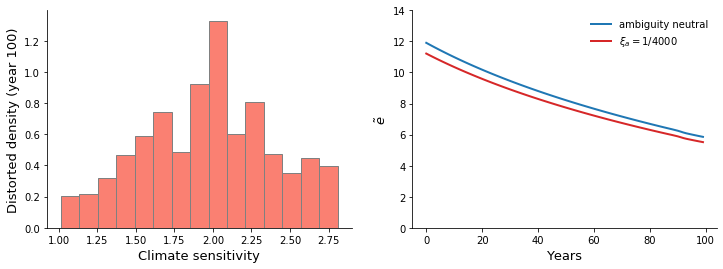

In [13]:
# plot 3
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.hist(θ_list*1000, weights=πt_avg[-1], density=True, bins=15, color="salmon", ec="grey")
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)


# ax2.plot(et_neutral, color='C0', label='ambiguity neutral', linewidth=2.)
ax2.plot(et_avg_no, color='C0', label='ambiguity neutral', linewidth=2.)
ax2.plot(et_avg, color='C3', label=r'$\xi_a = 1/4000$', linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
ax2.legend(frameon=False, loc='upper right')
ax2.set_ylim(0, 14)
# plt.savefig("../figures/hist_ems.pdf")

In [ ]:
# histogram 10, 50, 90
colors = plotly.colors.qualitative.Set1
colors18 = plotly.colors.cyclical.IceFire
colors[5] = 'rgb(230,171,2)'

fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(6,12))
ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 10)', fontsize=13)


ax2.hist(θ_list*1000, weights=πt_avg[50]*np.exp(-50*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Distorted density (year 50)', fontsize=13)

ax2.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Distorted density (year 50)', fontsize=13)


ax3.hist(θ_list*1000, weights=πt_avg[90]*np.exp(-90*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
ax3.set_xlabel('Climate sensitivity', fontsize=13)
ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

ax3.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
ax3.set_xlabel('Climate sensitivity', fontsize=13)
ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

In [ ]:
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
ξₐ = 1000
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_neutral, ems_neutral, π_neutral = solve_smooth(y_grid, args)

In [ ]:
yt_neutral, et_neutral, πt_neutral = simulate_traj(y_grid, ems_neutral, π_neutral, θ_list)

# ase 2: bring h back in

$$
\begin{aligned}
0 = \max_{\tilde e} \min_h \min_{\pi^c} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& + \sum \pi^c_i \left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_i \\
& + \left[ \frac{d\phi}{dy} + (\eta - 1 )(\gamma_1 + \gamma_2 y)\right]\tilde e \sigma_y h\\
& + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + \frac{\xi_m}{2}h'h + \xi_a \sum \pi^c_i (\log \pi^c_i - \log \hat\pi^c_i)
\end{aligned}
$$

Minimize over $h$:
$$
h^* = - \cfrac{\frac{d\phi}{dy} + (\eta - 1 )(\gamma_1 + \gamma_2 y)}{\xi_m}\cdot\tilde e \sigma_y
$$

Plug back in:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^c} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& + \sum \pi^c_i \left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_i \\
& + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& - \frac{1}{2\xi_m}\left[ \frac{d\phi}{dy} + (\eta - 1 )(\gamma_1 + \gamma_2 y)\right]^2 (\tilde e)^2 |\sigma_y|^2\\
&  + \xi_a \sum \pi^c_i (\log \pi^c_i - \log \hat\pi^c_i)
\end{aligned}
$$

Optimald distribution:
$$
\pi^c_j \propto \hat\pi^c_j \exp\left( -\frac{1}{\xi_a}\left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_j \right)
$$


First order condition for $\tilde e^*$:

$$
  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2\phi(y)}{dy^2}\right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j \tilde e + \delta\eta = 0
$$

$$
A =  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2\phi(y)}{dy^2}\right] \cdot|\sigma_y|^2
$$

$$
B = \sum_j \pi_j^c \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j
$$

$$
C = \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$
Here we set $\xi_a = 1000$, so there is no ambiguity.

In [ ]:
def solve_smooth_robust(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξₘ = args
    dy = y_grid[1] - y_grid[0]
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
    ϕ = - δ*η*y_grid**2
    ems = δ*η
    ems_old = ems
    πo = np.ones((len(θ_list), n_y))/len(θ_list)
    lhs_error = 1
    episode = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy)
        dϕdyy = derivative_1d(ϕ, 2, dy)
        temp = dϕdy + (η-1)*dΛ
        # update belief
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
        a = dϕdyy*σy**2 - temp**2*σy**2/ξₘ
        b = (θ_list@π)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*1. + ems_old*0.
        # solve for ode
        A = - δ*np.ones(y_grid.shape)
        B = (θ_list@π)*ems
        C = ems**2*σy**2/2
        D = δ*η*np.log(ems) + (θ_list@π)*(η-1)*dΛ*ems \
        + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
        - temp**2*ems**2*σy**2/(2*ξₘ)
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems, π

In [ ]:
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
ξₐ = 1000
ξₘ = 0.004
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξₘ)
ϕ_rbt, ems_rbt, π_rbt = solve_smooth_robust(y_grid, args)

In [ ]:
yt_rbt, et_rbt, πt_rbt = simulate_traj(y_grid, ems_rbt, π_rbt, θ_list)

In [ ]:
def compute_h_star(ϕ, ems, y_grid, args):
    η, σy, γ1, γ2, γ3, ȳ, ξₘ = args
    dy = y_grid[1] - y_grid[0]
    dϕdy = derivative_1d(ϕ, 1, dy)
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    h_star = dϕdy + (η-1)*dΛ
    h_star *= ems*σy
    h_star *= - 1/ξₘ
    return h_star

In [ ]:
args = (η, σy, γ1, γ2, γ3, ȳ, ξₘ)
h_star = compute_h_star(ϕ_rbt, ems_rbt, y_grid, args)

In [ ]:
plt.plot(y_grid, h_star)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.hist(θ_list*1000, weights=πt_rbt[-1], density=True, bins=15, color="salmon", ec="grey")
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)

ax2.plot(et_avg_no, color='C3', label=r'$\xi_a = 1000$', linewidth=2.)
ax2.plot(et_rbt, color='C0', label='ambiguity neutral', linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
ax2.legend(frameon=False, loc='upper right')
ax2.set_ylim(0, 14)

In [ ]:
def simulate_traj_robust(y_grid, ems, π_mat, h_star, θ_list,  dt=1, T=100):
    # initiate
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    h_t = np.zeros(periods)
    π_t = np.zeros((periods, len(θ_list)))
    # interpolate
    get_π = interpolate.interp1d(y_grid, π_mat)
    y0 = θ_list.mean()*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        h_point = np.interp(y, y_grid, h_star)
        π_list = get_π(y)
        ems_t[t] = ems_point
        h_t[t] = h_point
        π_t[t] = π_list
        dy = ems_point*(θ_list@π_list)*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t, π_t, h_t

In [ ]:
yt_rbt, et_rbt, πt_rbt, ht_rbt = simulate_traj_robust(y_grid, ems_rbt, π_rbt, h_star, θ_list)

In [ ]:
fig, ax1 = plt.subplots(1, 1,figsize=(6,4))
ax1.hist((θ_list + σy*ht_rbt[-1])*1000, weights=πt_rbt[-1], density=True, bins=15, color="salmon", ec="grey")
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)
ax1.hist((θ_list + σy*ht_rbt[0])*1000,  density=True, bins=15, color="grey", ec="grey", alpha=0.5)
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)

# Decompose ambiguity among climate models

#1 Partition over temp models

There are 16 temp models

In [ ]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θtemp_list = list()
for i in range(n_temp):
    same_temp = θ_list[i*n_carb:i*n_carb+n_carb+1]
    θtemp_list.append(np.average(same_temp))

In [ ]:
θtemp_list = np.array(θtemp_list)

In [ ]:
ξₐ = 1/4000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θtemp_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_temp, ems_temp, π_temp = solve_smooth(y_grid, args)

In [ ]:
plt.plot(ems_temp)

In [ ]:
yt_temp, et_temp, πt_temp = simulate_traj(y_grid, ems_temp, π_temp, θtemp_list)

In [ ]:
plt.plot(et_temp)

#2 Partition over carbon models

There are 9 carbon models.

In [ ]:
θcarb_list = list()
for i in range(n_carb):
    idx_carb = np.arange(i, n_θ+i, n_carb)
    same_carb = θ_list[idx_carb]
    θcarb_list.append(np.average(same_carb))

In [ ]:
θcarb_list = np.array(θcarb_list)

In [ ]:
ξₐ = 1/4000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θcarb_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_carb, ems_carb, π_carb = solve_smooth(y_grid, args)

In [ ]:
yt_carb, et_carb, πt_carb = simulate_traj(y_grid, ems_carb, π_carb, θcarb_list)

In [ ]:
plt.plot(et_neutral, label="no ambiguity")
plt.plot(et_carb, label="partition over carbon model")
plt.plot(et_temp, label="partition over temperature models")
plt.plot(et_avg, label = "ambiguity over climate models")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Years")
plt.ylabel('Emission')
plt.ylim(0,13.5)
# plt.savefig("../figures/ems_partition.pdf")

In [ ]:
ξₐ = 1/10_000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_avg, ems_avg, π_avg = solve_smooth(y_grid, args, tol=1e-6)
args = (δ, η, θtemp_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_temp, ems_temp, π_temp = solve_smooth(y_grid, args, tol=1e-6)
args = (δ, η, θcarb_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_carb, ems_carb, π_carb = solve_smooth(y_grid, args, tol=1e-6)
yt_avg, et_avg, πt_avg = simulate_traj(y_grid, ems_avg, π_avg, θ_list)
yt_temp, et_temp, πt_temp = simulate_traj(y_grid, ems_temp, π_temp, θtemp_list)
yt_carb, et_carb, πt_carb = simulate_traj(y_grid, ems_carb, π_carb, θcarb_list)

In [ ]:
plt.plot(et_neutral, label="no ambiguity")
plt.plot(et_carb, label="partition over carbon model")
plt.plot(et_temp, label="partition over temperature models")
plt.plot(et_avg, label = "ambiguity over climate models")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Years")
plt.ylabel('$\\tilde e$')
plt.ylim(0,13.5)
# plt.savefig("../figures/ems_partition.pdf")